In [2]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load Data

In [22]:
series_matrix = pd.read_csv('data/GSE68086_series_matrix.csv')
print(series_matrix.shape)
print(series_matrix.head())

(285, 46)
  !Sample_geo_accession           !Sample_status !Sample_submission_date  \
0          "GSM1662534"  "Public on Oct 30 2015"           "Apr 21 2015"   
1          "GSM1662535"  "Public on Oct 30 2015"           "Apr 21 2015"   
2          "GSM1662536"  "Public on Oct 30 2015"           "Apr 21 2015"   
3          "GSM1662537"  "Public on Oct 30 2015"           "Apr 21 2015"   
4          "GSM1662538"  "Public on Oct 30 2015"           "Apr 21 2015"   

  !Sample_last_update_date !Sample_type !Sample_channel_count  \
0            "May 15 2019"        "SRA"                   "1"   
1            "May 15 2019"        "SRA"                   "1"   
2            "May 15 2019"        "SRA"                   "1"   
3            "May 15 2019"        "SRA"                   "1"   
4            "May 15 2019"        "SRA"                   "1"   

  !Sample_source_name_ch1 !Sample_organism_ch1 !Sample_characteristics_ch1  \
0    "3-Breast-Her2-ampl"       "Homo sapiens"             "tiss

In [3]:
TEP_data = pd.read_csv('data/GSE68086_TEP_data_matrix.csv')
print(TEP_data.shape)
print(TEP_data.head())

(57736, 286)
        Unnamed: 0  3-Breast-Her2-ampl  8-Breast-WT  10-Breast-Her2-ampl  \
0  ENSG00000000003                   0            0                    0   
1  ENSG00000000005                   0            0                    0   
2  ENSG00000000419                  44           14                   16   
3  ENSG00000000457                  26            1                   14   
4  ENSG00000000460                  81           98                   18   

   Breast-100  15-Breast-Her2-ampl  16-Breast-WT  21-Breast-WT  \
0           0                   17             0             0   
1           0                    0             0             0   
2           8                    9             0           139   
3           0                    4            20             1   
4          17                    0            20           144   

   33-Breast-Her2-ampl  42-Breast-Her2-ampl  ...  MGH-NSCLC-L20-TR500  \
0                    0                    0  ...            

# Clean Data

In [27]:
# Keep only the sample source and cancer type columns
series_matrix_source_cancer = series_matrix[['!Sample_source_name_ch1', '!Sample_characteristics_ch1.3']]
# Rename the columns
series_matrix_source_cancer.columns = ['Sample', 'Cancer_Type']
# Delete the double quotes in the source
series_matrix_source_cancer['Sample'] = series_matrix_source_cancer['Sample'].str.replace('"', '')
# Delete the cancer type in str
series_matrix_source_cancer['Cancer_Type'] = series_matrix_source_cancer['Cancer_Type'].str.replace('cancer type: ', '')
series_matrix_source_cancer['Cancer_Type'] = series_matrix_source_cancer['Cancer_Type'].str.replace('"', '')
# One hot encode the cancer type
series_matrix_source_cancer = pd.get_dummies(series_matrix_source_cancer, columns=['Cancer_Type'])
print(series_matrix_source_cancer.head())

# Write the data to a csv file
series_matrix_source_cancer.to_csv('data/series_matrix_source_cancer.csv', index=False)

                Sample  Cancer_Type_Breast  Cancer_Type_CRC  Cancer_Type_GBM  \
0   3-Breast-Her2-ampl                True            False            False   
1          8-Breast-WT                True            False            False   
2  10-Breast-Her2-ampl                True            False            False   
3           Breast-100                True            False            False   
4  15-Breast-Her2-ampl                True            False            False   

   Cancer_Type_HC  Cancer_Type_Hepatobiliary  Cancer_Type_Lung  \
0           False                      False             False   
1           False                      False             False   
2           False                      False             False   
3           False                      False             False   
4           False                      False             False   

   Cancer_Type_Pancreas  Cancer_Type_mutational subclass: EGFR  \
0                 False                                 

/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3jh0000gn/T/ipykernel_83460/698329259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_matrix_source_cancer['Sample'] = series_matrix_source_cancer['Sample'].str.replace('"', '')
/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3jh0000gn/T/ipykernel_83460/698329259.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_matrix_source_cancer['Cancer_Type'] = series_matrix_source_cancer['Cancer_Type'].str.replace('cancer type: ', '')
/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3

In [28]:
# Load the data
patient_data = pd.read_csv('data/series_matrix_source_cancer.csv')
rna_expression = pd.read_csv('data/GSE68086_TEP_data_matrix.csv', index_col=0)
# print(patient_data.head())

# Reset the index to make the index a regular column
rna_expression.reset_index(inplace=True)
# Rename the index column to 'gene_ID'
rna_expression.rename(columns={'index': 'gene_ID'}, inplace=True)

# Reshape data from wide to long format
rna_expression_long = rna_expression.melt(id_vars=['gene_ID'], var_name='Sample', value_name='FPKM')

# print(rna_expression_long.head())

# Merge the patient data with the rna expression data
patient_data['Sample'] = patient_data['Sample']
merged_data = pd.merge(rna_expression_long, patient_data, on='Sample')
print(merged_data.head())

# Write the data to a csv file
merged_data.to_csv('data/merged_data.csv', index=False)


           gene_ID              Sample  FPKM  Cancer_Type_Breast  \
0  ENSG00000000003  3-Breast-Her2-ampl     0                True   
1  ENSG00000000005  3-Breast-Her2-ampl     0                True   
2  ENSG00000000419  3-Breast-Her2-ampl    44                True   
3  ENSG00000000457  3-Breast-Her2-ampl    26                True   
4  ENSG00000000460  3-Breast-Her2-ampl    81                True   

   Cancer_Type_CRC  Cancer_Type_GBM  Cancer_Type_HC  \
0            False            False           False   
1            False            False           False   
2            False            False           False   
3            False            False           False   
4            False            False           False   

   Cancer_Type_Hepatobiliary  Cancer_Type_Lung  Cancer_Type_Pancreas  \
0                      False             False                 False   
1                      False             False                 False   
2                      False             Fal

In [4]:
# Produce a smaller dataset to test the model
# Load the data
patient_data = pd.read_csv('data/series_matrix_source_cancer.csv')
rna_expression = pd.read_csv('data/GSE68086_TEP_data_matrix.csv', index_col=0)[:5000]
# print(patient_data.head())

# Reset the index to make the index a regular column
rna_expression.reset_index(inplace=True)
# Rename the index column to 'gene_ID'
rna_expression.rename(columns={'index': 'gene_ID'}, inplace=True)

# Reshape data from wide to long format
rna_expression_long = rna_expression.melt(id_vars=['gene_ID'], var_name='Sample', value_name='FPKM')

# print(rna_expression_long.head())

# Merge the patient data with the rna expression data
patient_data['Sample'] = patient_data['Sample']
merged_data = pd.merge(rna_expression_long, patient_data, on='Sample')
print(merged_data.head())

# Write the data to a csv file
merged_data.to_csv('data/merged_data_5k.csv', index=False)

           gene_ID              Sample  FPKM  Cancer_Type_Breast  \
0  ENSG00000000003  3-Breast-Her2-ampl     0                True   
1  ENSG00000000005  3-Breast-Her2-ampl     0                True   
2  ENSG00000000419  3-Breast-Her2-ampl    44                True   
3  ENSG00000000457  3-Breast-Her2-ampl    26                True   
4  ENSG00000000460  3-Breast-Her2-ampl    81                True   

   Cancer_Type_CRC  Cancer_Type_GBM  Cancer_Type_HC  \
0            False            False           False   
1            False            False           False   
2            False            False           False   
3            False            False           False   
4            False            False           False   

   Cancer_Type_Hepatobiliary  Cancer_Type_Lung  Cancer_Type_Pancreas  \
0                      False             False                 False   
1                      False             False                 False   
2                      False             Fal

# Visualize Data

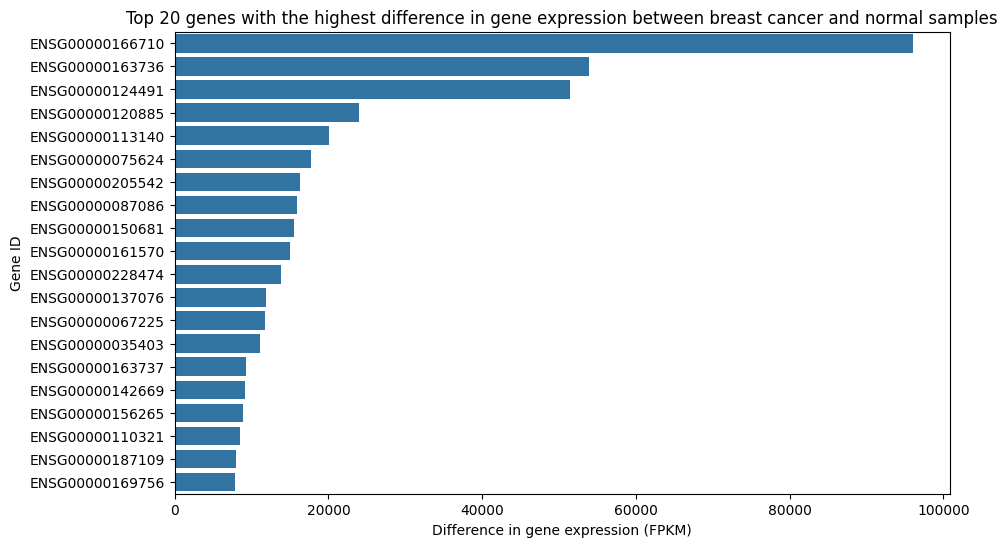

In [33]:
merged_data = pd.read_csv('data/merged_data.csv')
# Compare the difference in gene expression between breast cancer and normal samples
# Select the breast cancer and normal samples
breast_cancer_patients = merged_data[(merged_data['Cancer_Type_Breast'] == 1)]
healthy_controls = merged_data[(merged_data['Cancer_Type_HC'] == 1)]

# Calculate the mean gene expression for each gene in breast cancer and normal samples
breast_cancer_mean_expression = breast_cancer_patients.groupby('gene_ID')['FPKM'].mean()
healthy_controls_mean_expression = healthy_controls.groupby('gene_ID')['FPKM'].mean()

# Calculate the difference in gene expression between breast cancer and normal samples
gene_expression_difference = breast_cancer_mean_expression - healthy_controls_mean_expression
# Sort the genes based on the difference in gene expression
gene_expression_difference = gene_expression_difference.sort_values(ascending=False)

# Plot the 20 genes with the highest difference in gene expression
plt.figure(figsize=(10, 6))
sns.barplot(x=gene_expression_difference.head(20).values, y=gene_expression_difference.head(20).index)
plt.xlabel('Difference in gene expression (FPKM)')
plt.ylabel('Gene ID')
plt.title('Top 20 genes with the highest difference in gene expression between breast cancer and normal samples')
plt.show()




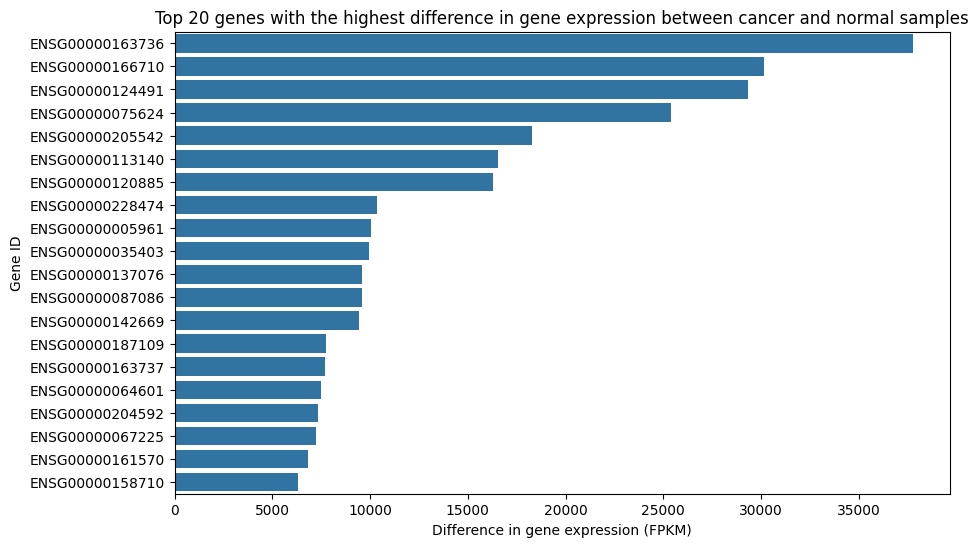

In [8]:
# Load the merged data
merged_data = pd.read_csv('data/merged_data.csv')

# Separate cancer patients and healthy controls
cancer_patients = merged_data[(merged_data['Cancer_Type_HC'] == 0)]
healthy_controls = merged_data[(merged_data['Cancer_Type_HC'] == 1)]

# Calculate the mean gene expression for each gene in cancer and normal samples
cancer_mean_expression = cancer_patients.groupby('gene_ID')['FPKM'].mean()
healthy_controls_mean_expression = healthy_controls.groupby('gene_ID')['FPKM'].mean()
gene_expression_difference = cancer_mean_expression - healthy_controls_mean_expression

# Sort the genes based on the difference in gene expression
gene_expression_difference = gene_expression_difference.sort_values(key=abs, ascending=False)

# Plot the 20 genes with the highest difference in gene expression
plt.figure(figsize=(10, 6))
sns.barplot(x=gene_expression_difference.head(20).values, y=gene_expression_difference.head(20).index)
plt.xlabel('Difference in gene expression (FPKM)')
plt.ylabel('Gene ID')
plt.title('Top 20 genes with the highest difference in gene expression between cancer and normal samples')
plt.show()



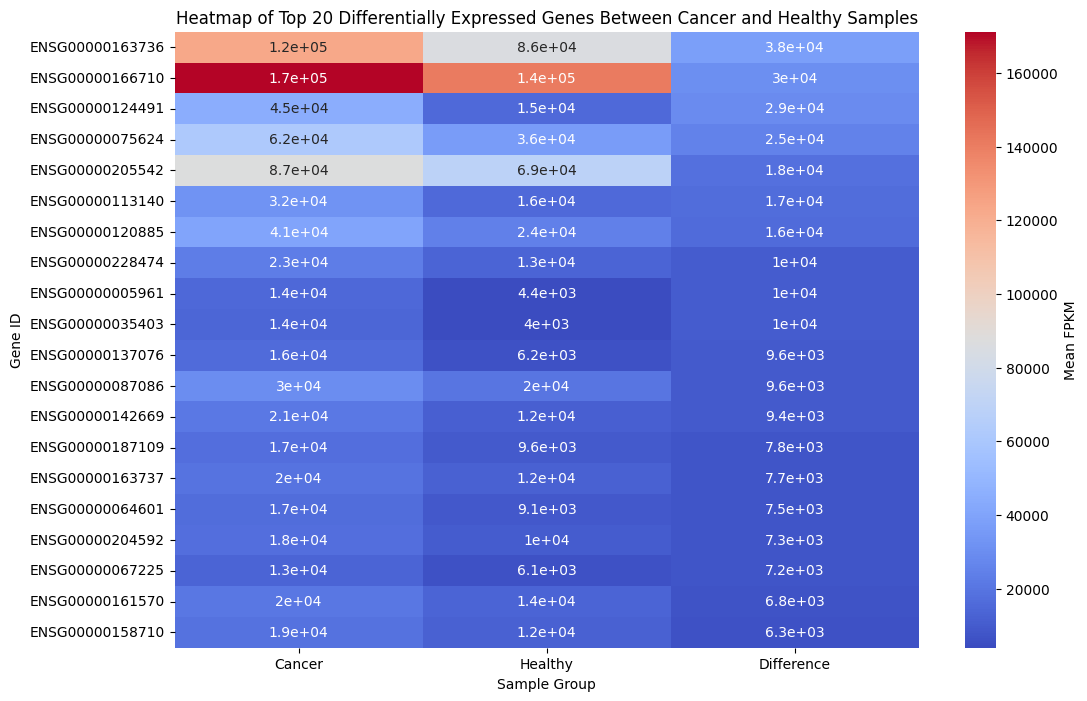

In [10]:
# Load the merged data
merged_data = pd.read_csv('data/merged_data.csv')

# Separate cancer patients and healthy controls
cancer_patients = merged_data[merged_data['Cancer_Type_HC'] == 0]
healthy_controls = merged_data[merged_data['Cancer_Type_HC'] == 1]

# Calculate the mean gene expression for each gene in cancer and normal samples
cancer_mean_expression = cancer_patients.groupby('gene_ID')['FPKM'].mean()
healthy_mean_expression = healthy_controls.groupby('gene_ID')['FPKM'].mean()

# Calculate the difference and sort based on the absolute difference in gene expression
gene_expression_difference = cancer_mean_expression - healthy_mean_expression
top_20_genes = gene_expression_difference.abs().nlargest(20).index

# Create a DataFrame for the heatmap with 'Cancer', 'Healthy', and 'Difference' columns
top_20_data = pd.DataFrame({
    'Cancer': cancer_mean_expression[top_20_genes],
    'Healthy': healthy_mean_expression[top_20_genes],
    'Difference': gene_expression_difference[top_20_genes]
})

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_20_data, cmap='coolwarm', annot=True, cbar_kws={'label': 'Mean FPKM'})
plt.title('Heatmap of Top 20 Differentially Expressed Genes Between Cancer and Healthy Samples')
plt.xlabel('Sample Group')
plt.ylabel('Gene ID')
plt.show()


/var/folders/x1/4ffcbyys3j9b4z3p5kdqn3jh0000gn/T/ipykernel_11671/1035816649.py:25: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


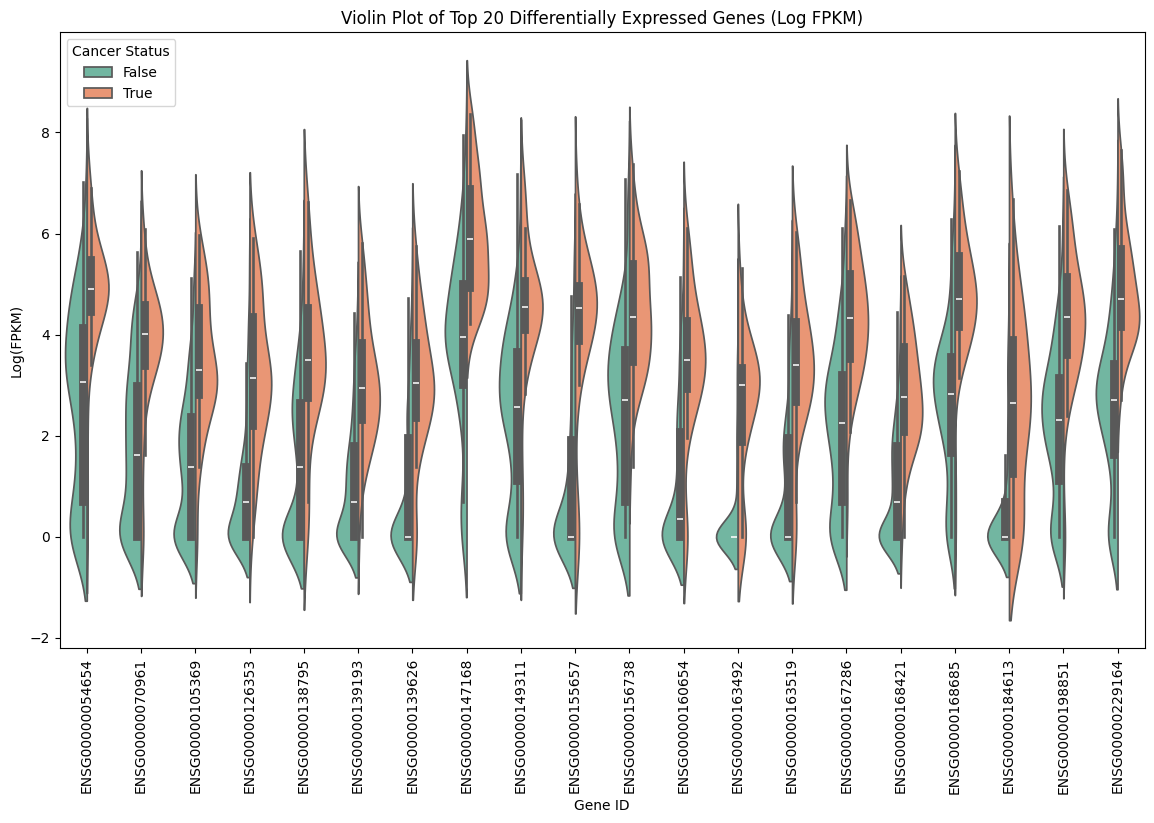

In [15]:
# Load the merged data
merged_data = pd.read_csv('data/merged_data.csv')

# Transform FPKM values to log scale (adding a small value to avoid log(0))
merged_data['Log_FPKM'] = np.log1p(merged_data['FPKM'])  # log1p handles zero by using log(1 + x)

# Separate cancer patients and healthy controls
cancer_patients = merged_data[merged_data['Cancer_Type_HC'] == 0]
healthy_controls = merged_data[merged_data['Cancer_Type_HC'] == 1]


# Calculate the mean log-transformed gene expression for each gene in cancer and normal samples
cancer_log_mean_expression = cancer_patients.groupby('gene_ID')['Log_FPKM'].mean()
healthy_log_mean_expression = healthy_controls.groupby('gene_ID')['Log_FPKM'].mean()

# Sort the genes based on the absolute difference in log-transformed gene expression and select the top 20
gene_expression_log_difference = cancer_log_mean_expression - healthy_log_mean_expression
top_20_genes = gene_expression_log_difference.abs().nlargest(20).index

# Filter the data for only the top 20 genes
top_20_log_data = merged_data[merged_data['gene_ID'].isin(top_20_genes)]

# Plot the violin plot with adjusted dodge and width
plt.figure(figsize=(14, 8))
sns.violinplot(
    data=top_20_log_data,
    x='gene_ID', 
    y='Log_FPKM', 
    hue='Cancer_Type_HC', 
    split=True,
    palette="Set2",
    dodge=True,  # Adjusting dodge for separation
    scale='width'  # Adjusting scale for better comparison
)
plt.title('Violin Plot of Top 20 Differentially Expressed Genes (Log FPKM)')
plt.xlabel('Gene ID')
plt.ylabel('Log(FPKM)')
plt.xticks(rotation=90)
plt.legend(title='Cancer Status')
plt.show()